In [1]:
experiment_name = "ballmapper_analysis"
computer = "ciara"
dataset_name = "MBC"

In [2]:
#ensure current version of hot-mapper is being implemented and home directory is correct for computer,
import sys
sys.path.append(F"C:/Users/{computer}/OneDrive/Documents/GitHub")

In [4]:
import numpy as np
import pandas as pd
import networkx as nx
from sklearn.preprocessing import MinMaxScaler

from matplotlib import pyplot as plt
%matplotlib inline

from tqdm.notebook import tqdm

from ciaratools import experiments, data_collections
from pyballmapper import BallMapper

In [5]:
# this cell allows for bokeh plots to be displayed inside jupyter notebooks
from bokeh.io import output_notebook
output_notebook() #opens in new tab

Loading BokehJS ...

In [6]:
from IPython.display import clear_output

In [7]:
#creating new folder to hold results for experiment in project path 
project_directory = F"C:/Users/{computer}/OneDrive/Documents/PhD File Transfer/Projects/Jurek Orr/MBC/ballmapper/"
output_path = experiments.results_folder(project_directory, experiment_name)

## Load in Male Breast Cancer data 

- Using the 2500 most variable genes dataset 
- provided by Sarah Oct 2019
- 114 Male Breast Cancer patients

In [8]:
#2500 most variable genes in z-score format
data_file = data_collections.AccessData(d=dataset_name, l=computer)
X_df_genes = pd.read_csv(F"C:/Users/{computer}/OneDrive/Documents/PhD File Transfer/Data/{dataset_name}/MBC_2500_most_variable.txt", delimiter='\t')
X_df = X_df_genes.T
X = X_df.values
print(X.shape) #patients in rows and genes in features 

(114, 2500)


In [9]:
X_df

,PI15,IL6ST,IGFBP5,COL1A1,FN1,SLC39A6,COL3A1,TRPS1,NPY1R,COL1A2,...,DSC2,STARD13,PFKFB3,LTF,LURAP1L,ITGB5,SKA2,FREM2,ATRN,AK3
E750001,-0.537413,0.100413,1.461142,0.334775,-0.067076,-0.490979,0.382364,-0.899712,-0.289416,0.127066,...,2.643893,-0.849926,-0.439467,-0.358580,-0.516559,-0.720118,3.320678,0.933627,1.361949,0.843666
E750002,-0.543927,1.245083,4.310890,0.153717,-0.070122,-0.707912,0.464345,2.346847,-0.352663,0.866365,...,-0.911362,1.734135,-0.871835,-0.463183,1.560143,0.568948,0.238705,-0.313811,1.002947,0.200260
E750003,2.005215,-0.641295,-0.647006,-1.134129,-1.235485,-0.478624,-1.109688,-0.644721,-0.429357,-1.139349,...,-0.920072,-0.191015,-1.010532,-0.085881,-0.329874,-1.503951,-0.686943,-0.343153,-0.327843,-1.275504
E750004,-0.520819,-0.574606,-0.425321,0.619539,1.533268,-0.733167,-0.072765,-0.550931,-0.396787,0.394190,...,-0.695316,-0.081680,0.913425,-0.250429,-0.883188,1.156123,-0.592004,-0.417998,-0.424075,-0.891293
E750005,-0.538356,-0.744217,-0.373130,0.421494,0.889184,-0.452832,0.451258,-0.635213,-0.310776,0.238174,...,0.384518,-0.973360,-0.479774,-0.393753,1.893592,-0.311821,0.490881,-0.421554,-0.846839,-0.880029
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
E750141,-0.542202,-0.867596,-0.480897,0.246426,0.521071,-0.732803,0.000785,-0.989853,-0.416959,0.201974,...,-1.065088,-0.969815,0.082506,-0.373208,-0.471136,0.410265,-1.178048,-0.455386,-1.283243,-0.899010
E750142,4.871940,2.305676,2.605726,-1.302292,-1.180092,1.933210,-1.272107,-0.645426,-0.358291,-1.249023,...,1.970788,2.242852,-0.568026,0.270423,0.070625,-0.258312,-0.852095,-0.509327,0.655909,-0.318047
E750143,-0.332875,0.126066,-0.238603,1.340525,0.945166,5.092889,1.402871,-0.644419,2.827001,1.115721,...,1.282617,-0.201138,-0.351754,-0.367861,-0.444413,0.030258,1.161892,-0.510723,1.960828,1.091627
F29_0005,0.619630,0.525843,-0.485476,-0.604079,-0.619324,0.702410,-0.606439,-0.587989,-0.400298,0.181550,...,-0.664291,-0.488099,-0.493875,0.565486,-0.505338,1.000885,0.716551,-0.452115,-0.315459,-0.476807


### M1 / M2 subtypes 

Using BallMapper on the M1M2 genes, we identified two obvious clusters

In [11]:
# #We can use NAT1 gene expression to colour the BallMapper 
# #NAT1 isn't in the 2500 variable genes, but we can obtain the values from the dataset containing all protein coding genes
# X_pcg = pd.read_csv(filepath_or_buffer =F"C:/Users/{computer}/OneDrive/Documents/PhD File Transfer/Data/{dataset_name}/MBC_zscored_pcg.csv", sep = ",", index_col = 0)
# print(X_pcg.shape)


m1m2 = pd.read_csv(F"C:/Users/{computer}/OneDrive/Documents/PhD File Transfer/Data/{dataset_name}/m1m2_cluster.txt",  delimiter='\t')

(114, 19935)


In [10]:
#include important information to colour graph with
y = pd.DataFrame({"ID": X_df.index, "M1M2" : m1m2.M1M2_clusters, "NAT1": list(X_pcg.NAT1)})

In [11]:
y

,ID,M1M2,NAT1
0,E750001,1,1.040136
1,E750002,0,-0.668197
2,E750003,2,-0.188314
3,E750004,1,-1.689925
4,E750005,1,0.351781
...,...,...,...
109,E750141,1,-0.042633
110,E750142,2,0.897551
111,E750143,1,0.841961
112,F29_0005,0,0.390456


## Create BallMapper graph

In [101]:
from scipy.spatial.distance import correlation
from matplotlib import cm

from pyballmapper import BallMapper
from pyballmapper.plotting import graph_GUI
from bokeh.plotting import figure, show


eps = 0.68
bm = BallMapper(points = X, # the pointcloud, as a numpy array
                    epsilon = eps,
                    distance = correlation,
                    dbg=True) # the radius of the balls

bm.add_coloring(coloring_df=pd.DataFrame(y, columns=['M1M2']))
clear_output() # newer versions of pandas produce a lot of warings when I launch the above function :)
my_palette = cm.get_cmap(name='plasma')

bm_gui = graph_GUI(bm.Graph,
                          my_palette,
                          tooltips_variables=['M1M2'])
bm_gui.color_by_variable('M1M2')
show(bm_gui.plot)


color by variable M1M2 
MIN_VALUE: 0.000, MAX_VALUE: 2.000


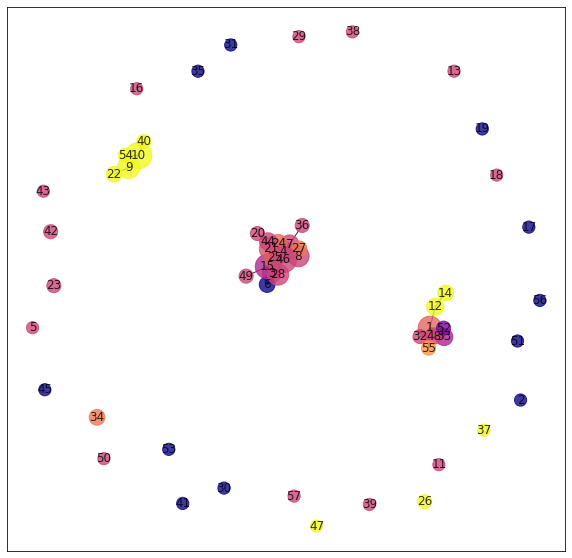

In [102]:
plt.figure(figsize = (10,10))
# The BallMapper class has a builtin plotting method, buit around nx.draw_networkx
bm.draw_networx(coloring_variable='M1M2', color_palette=my_palette)
plt.show()

## Can also look at cosine distance

In [103]:
# from scipy.spatial.distance import cosine
# from matplotlib import cm

# from pyballmapper import BallMapper
# from pyballmapper.plotting import graph_GUI
# from bokeh.plotting import figure, show


# eps = 0.45
# bm = BallMapper(points = X, # the pointcloud, as a numpy array
#                     epsilon = eps,
#                     distance = cosine,
#                     dbg=True) # the radius of the balls

# bm.add_coloring(coloring_df=pd.DataFrame(y, columns=['M1M2']))
# clear_output() # newer versions of pandas produce a lot of warings when I launch the above function :)
# my_palette = cm.get_cmap(name='plasma')

# bm_gui = graph_GUI(bm.Graph,
#                           my_palette,
#                           tooltips_variables=['M1M2'])
# bm_gui.color_by_variable('M1M2')
# show(bm_gui.plot)


## Create labels for the three clusters 
found in the BallMapper graph of the 2500 most variable genes

In [104]:
def component_samples(nodes):
    """return a set of all the unique samples covered by the connected node clusters in BallMapper"""
    long_node_list = [bm.points_covered_by_landmarks[i] for i in nodes]
    flat_list = [item for sublist in long_node_list for item in sublist]
    return set(flat_list)

def label_large_clusters(bm_graph):
    """Return a list of labels for the large clusters found in the BallMapper graph. 
    Samples labelled 0 are outliers"""
    
    C = nx.connected_components(bm_graph)
    S = [bm_graph.subgraph(c).copy() for c in nx.connected_components(bm_graph)]
    S_nodes = [(i.nodes) for i in S]
    #identify clusters with more than one node
    count = 0
    cluster_labels = [0] * len(X)

    for i in S_nodes:
        if len(i) > 2:
            count += 1
            samples = component_samples(i)
            print(count, i, samples, len(samples))
            for s in samples:
                cluster_labels[s] = count 
    return cluster_labels


In [105]:
#label clusters to see how they correspond to reverse ordering and various radii
labels = label_large_clusters(bm.Graph)
y["clusters"] = labels

print(y)
print()
print(y.clusters.value_counts())

1 [32, 1, 33, 12, 14, 48, 52, 55] {0, 11, 13, 25, 26, 28, 29, 30, 48, 57, 58, 61, 71, 76, 84, 89, 94, 95, 106, 111} 20
2 [3, 4, 36, 6, 7, 8, 44, 46, 15, 49, 20, 21, 24, 25, 27, 28] {2, 3, 5, 6, 7, 14, 15, 16, 22, 23, 24, 32, 34, 37, 38, 40, 41, 42, 43, 44, 46, 47, 49, 50, 51, 52, 63, 74, 75, 78, 85, 87, 91, 93, 97, 98, 99, 101, 103, 105, 109} 41
3 [40, 9, 10, 54, 22] {8, 9, 21, 27, 31, 33, 36, 39, 54, 64, 67, 70, 72, 73, 79, 82, 83, 90, 92, 110} 20
           ID  M1M2      NAT1  clusters
0     E750001     1  1.040136         1
1     E750002     0 -0.668197         0
2     E750003     2 -0.188314         2
3     E750004     1 -1.689925         2
4     E750005     1  0.351781         0
..        ...   ...       ...       ...
109   E750141     1 -0.042633         2
110   E750142     2  0.897551         3
111   E750143     1  0.841961         1
112  F29_0005     0  0.390456         0
113  F29_0006     1 -1.382121         0

[114 rows x 4 columns]

2    41
0    33
1    20
3    20
Name: clus

In [106]:
y.clusters.value_counts()

2    41
0    33
1    20
3    20
Name: clusters, dtype: int64

In [107]:
bm.add_coloring(coloring_df=pd.DataFrame(y))
clear_output()

bm_gui = graph_GUI(bm.Graph,
                          my_palette,
                          tooltips_variables=['clusters'])
bm_gui.color_by_variable('clusters')
show(bm_gui.plot)


color by variable clusters 
MIN_VALUE: 0.000, MAX_VALUE: 3.000


- outliers = blue
- M1 = orange
- M2 = yellow
- Cluster of interest = pink

In [108]:
import numpy as np 
from pyballmapper import BallMapper
from scipy.spatial.distance import cosine


In [109]:
radii_list =[i/25.0 for i in range(1, 31)]
print(radii_list)

[0.04, 0.08, 0.12, 0.16, 0.2, 0.24, 0.28, 0.32, 0.36, 0.4, 0.44, 0.48, 0.52, 0.56, 0.6, 0.64, 0.68, 0.72, 0.76, 0.8, 0.84, 0.88, 0.92, 0.96, 1.0, 1.04, 1.08, 1.12, 1.16, 1.2]


In [110]:
output = {}

# array of radii

is_sorted = lambda a: np.all(a[:-1] <= a[1:])
assert(is_sorted(radii_list))

# run BM on the first radius
cc_dict = {}
bm = BallMapper(points = X,     # the pointcloud, as a numpy array
                epsilon = radii_list[0],
               distance = correlation)  # the radius of the balls

# iterate through a sorted list of connected components, largest first.
for i, cc in enumerate(sorted(nx.connected_components(bm.Graph), key=len, reverse=True)):
    # for each connected components, find the set of points covered by its nodes
    points_in_cc = set().union(*[bm.points_covered_by_landmarks[idx] for idx in cc])
    cc_dict[i] =  points_in_cc

output[radii_list[0]] = cc_dict

# run BM for the other radii and keep track of how the connected components
# evolve
for i, eps in enumerate(radii_list[1:], start=1):
    cc_dict = {}
    bm = BallMapper(points = X,     # the pointcloud, as a numpy array
                    epsilon = eps,
                   distance = correlation)  # the radius of the balls

    # in order to be consistent with the naming, look for cc in the previous BM
    # that contains some of the points in the current cc
    # iterate through a sorted list of connected components, largest first.
    for cc in sorted(nx.connected_components(bm.Graph), key=len, reverse=True):
        # for each connected components, find the set of points covered by its nodes
        points_in_cc = set().union(*[bm.points_covered_by_landmarks[idx] for idx in cc])
        # look for the first cc in the previous bm that is a subset of the current cc
        # this will be the name for our current cc
        for old_cc_name in sorted(output[radii_list[i-1]].keys()):
            if output[radii_list[i-1]][old_cc_name].issubset(points_in_cc):
                break
        cc_dict[old_cc_name] =  points_in_cc

    output[eps] = cc_dict

In [111]:
## this are the ids of the clusters at different radii
## note that the clusters id are integers, not cc_i !! 
for k in output:
    print(k, output[k].keys())

0.04 dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113])
0.08 dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113])
0.12 dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 

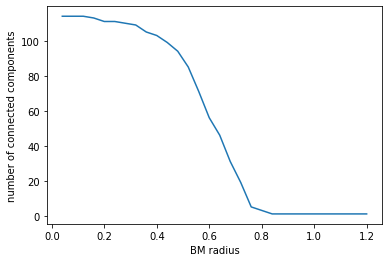

In [112]:
# lets see how the number of cc varies
fig, ax = plt.subplots()

ax.plot(radii_list, [len(output[eps].keys()) for eps in output])

ax.set_xlabel('BM radius')
ax.set_ylabel('number of connected components')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


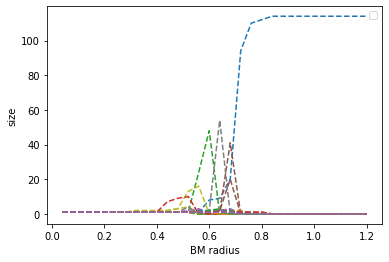

In [113]:
fig, ax = plt.subplots()

# we plot the size of the cc that survive at least till min_eps = 0.5

min_eps = 0.52

#mkrs = ['o', 'v', 's', 'P', 'p', '*']

for cc_id in sorted(output[min_eps].keys()): 
    ax.plot(radii_list, [len(output[key].get(cc_id, [])) for key in output],linestyle='dashed')

ax.set_xlabel('BM radius')
ax.set_ylabel('size')

ax.legend()

plt.show()

0
{0, 11, 13, 25, 26, 28, 29, 30, 48, 57, 58, 61, 71, 76, 84, 89, 94, 95, 106, 111}
5
{2, 3, 5, 6, 7, 14, 15, 16, 22, 23, 24, 32, 34, 37, 38, 40, 41, 42, 43, 44, 46, 47, 49, 50, 51, 52, 63, 74, 75, 78, 85, 87, 91, 93, 97, 98, 99, 101, 103, 105, 109}
35
{96, 35}
45
{66, 45}
59
{108, 59, 60}
72
{8, 9, 21, 27, 31, 33, 36, 39, 54, 64, 67, 70, 72, 73, 79, 82, 83, 90, 92, 110}
80
{80, 102}


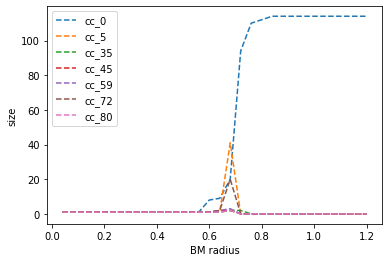

In [114]:
min_eps =0.68
fig, ax = plt.subplots()


for cc_id in sorted(output[min_eps].keys()): 
    if len(output[min_eps][cc_id]) >= 2:
        print(cc_id)
        print(output[min_eps][cc_id])
        ax.plot(radii_list, [len(output[key].get(cc_id, [])) for key in output],
                label = 'cc_{}'.format(cc_id), linestyle='dashed')
        
ax.set_xlabel('BM radius')
ax.set_ylabel('size')

ax.legend()

plt.show()

In [ ]:
output.keys()